Current Working Directory: d:\SPAI_Lab\Project\HELIXON\RaD_team1_HELIXON\kalman
Found file: d:\SPAI_Lab\Project\HELIXON\RaD_team1_HELIXON\kalman\../utils/spiral_data/sensor_data_up_b.csv


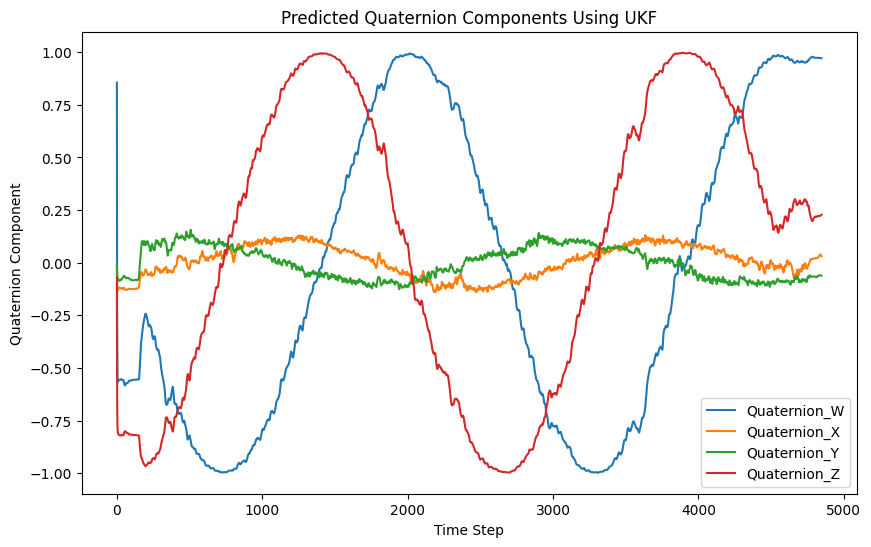

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
import view_plot

# Checking and printing the current working directory
print(f"Current Working Directory: {os.getcwd()}")

# Define file path relative to the current working directory
data_file_path = "../utils/spiral_data/sensor_data_up_b.csv"
full_data_file_path = os.path.join(os.getcwd(), data_file_path)

# Checking if the path exists
if not os.path.exists(full_data_file_path):
    print(f"File not found: {full_data_file_path}")
else:
    print(f"Found file: {full_data_file_path}")

# Reading the CSV file
sensor_data_df = pd.read_csv(full_data_file_path)

# Assuming the dataframe includes columns 'Quaternion_W', 'Quaternion_X', 'Quaternion_Y', 'Quaternion_Z' for quaternions
quaternion_data = sensor_data_df[['Quaternion_W', 'Quaternion_X', 'Quaternion_Y', 'Quaternion_Z']].values

# Initialize and configure Unscented Kalman Filter (UKF)
dim_x = 4
dim_z = 4
points = MerweScaledSigmaPoints(n=dim_x, alpha=0.1, beta=2.0, kappa=0.0)
ukf = UKF(dim_x=dim_x, dim_z=dim_z, fx=lambda x, dt: x, hx=lambda x: x, dt=1/25, points=points)
ukf.x = np.array([1, 0, 0, 0])  # Initial state
ukf.P *= 0.1  # Initial covariance

# Predict states with UKF
predicted_states = []
for q in quaternion_data:
    q = q / np.linalg.norm(q)
    ukf.predict()
    ukf.update(q)
    predicted_states.append(ukf.x)
predicted_states = np.array(predicted_states)

# Plotting the quaternion components
plt.figure(figsize=(10, 6))
plt.plot(predicted_states[:, 0], label='Quaternion_W')
plt.plot(predicted_states[:, 1], label='Quaternion_X')
plt.plot(predicted_states[:, 2], label='Quaternion_Y')
plt.plot(predicted_states[:, 3], label='Quaternion_Z')
plt.title('Predicted Quaternion Components Using UKF')
plt.xlabel('Time Step')
plt.ylabel('Quaternion Component')
plt.legend()
plt.show()

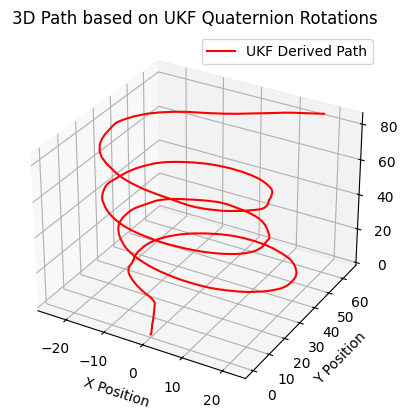

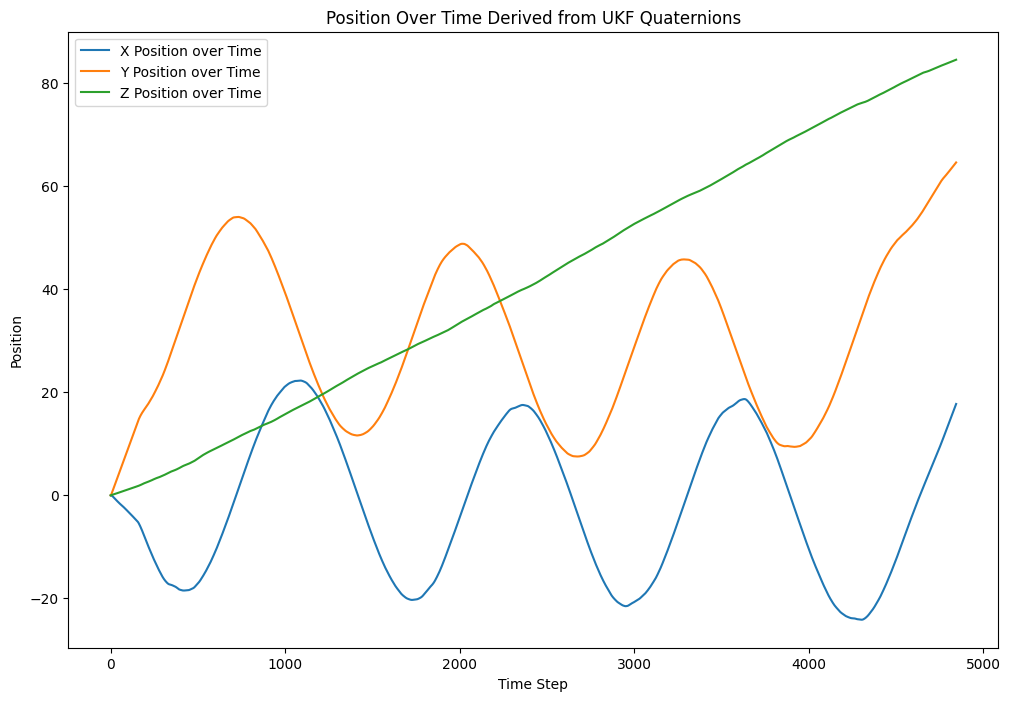

In [6]:
# Function to convert quaternion to rotation matrix
def quaternion_to_matrix(q):
    w, x, y, z = q
    return np.array([
        [1 - 2 * y ** 2 - 2 * z ** 2, 2 * x * y - 2 * z * w, 2 * x * z + 2 * y * w],
        [2 * x * y + 2 * z * w, 1 - 2 * x ** 2 - 2 * z ** 2, 2 * y * z - 2 * x * w],
        [2 * x * z - 2 * y * w, 2 * y * z + 2 * x * w, 1 - 2 * x ** 2 - 2 * y ** 2]
    ])


# Initialize a position array using the number of UKF steps
num_steps = len(predicted_states)
ukf_positions = np.zeros((num_steps, 3))

# Assuming a constant movement direction (e.g., x-axis) and step size
initial_velocity = np.array([0.1, 0, 0])

# Calculate positions based on UKF quaternion-derived rotations
for i in range(1, num_steps):
    rotation_matrix = quaternion_to_matrix(predicted_states[i])
    ukf_positions[i] = ukf_positions[i - 1] + rotation_matrix @ initial_velocity

# Plotting the resulting 3D path from quaternion-derived positions
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(ukf_positions[:, 0], ukf_positions[:, 1], ukf_positions[:, 2], label='UKF Derived Path', color='r')
ax.set_title('3D Path based on UKF Quaternion Rotations')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')
plt.legend()
plt.show()

# Plot positions over time
plt.figure(figsize=(12, 8))
plt.plot(ukf_positions[:, 0], label='X Position over Time')
plt.plot(ukf_positions[:, 1], label='Y Position over Time')
plt.plot(ukf_positions[:, 2], label='Z Position over Time')
plt.title('Position Over Time Derived from UKF Quaternions')
plt.xlabel('Time Step')
plt.ylabel('Position')
plt.legend()
plt.show()

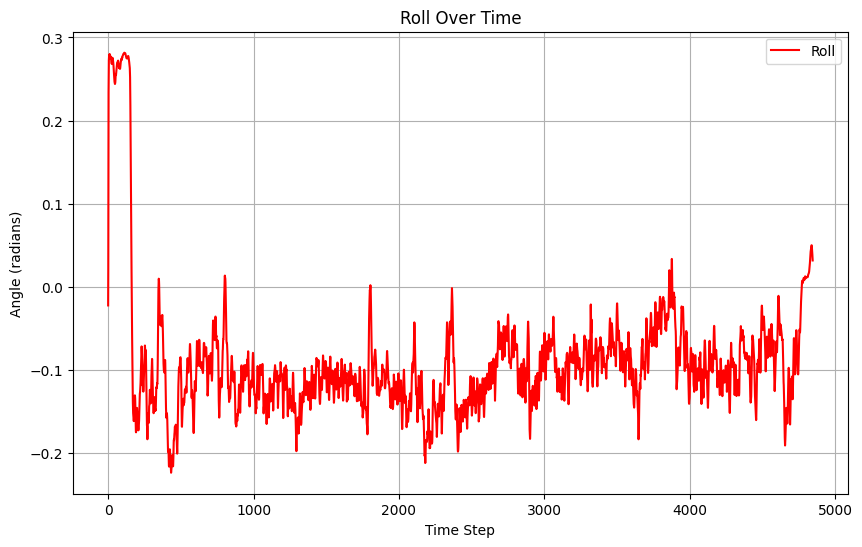

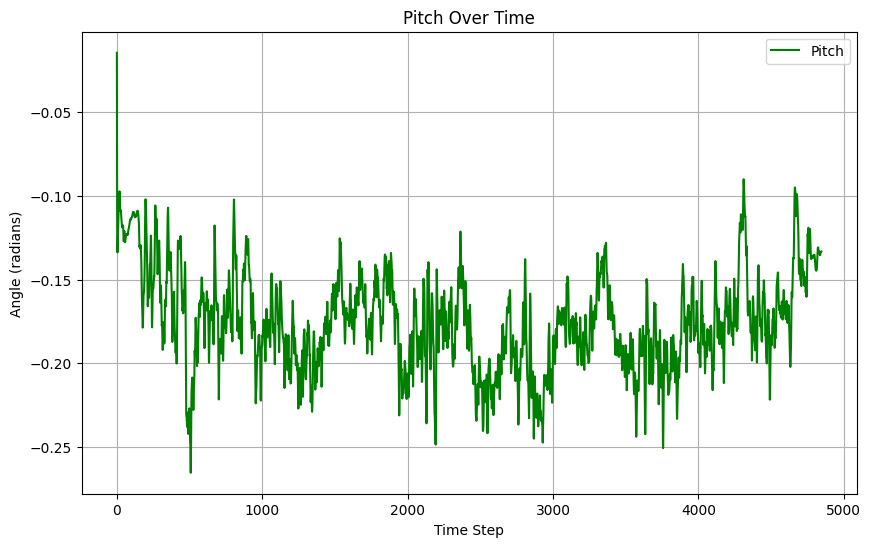

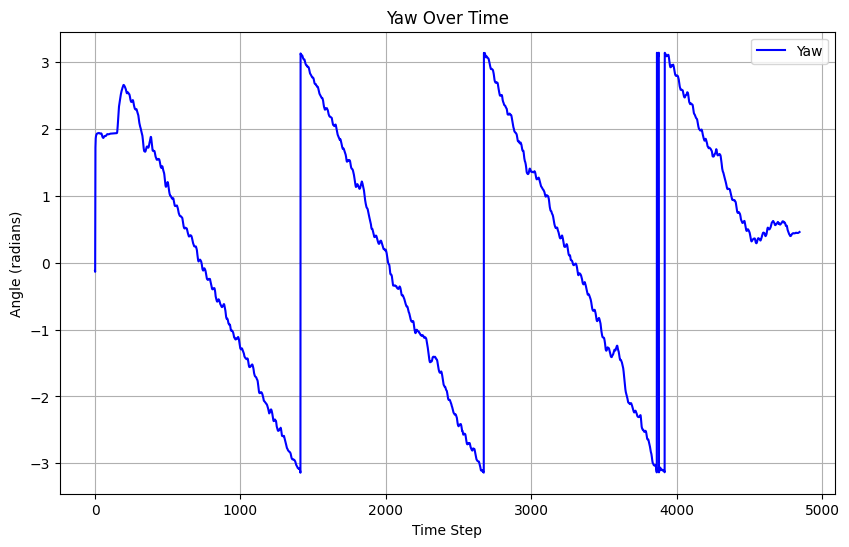

In [7]:
def quaternion_to_euler_angles(q):
    """
    Convert quaternion to Euler angles (roll, pitch, yaw) in radians.
    Quaternion format assumed as [w, x, y, z].
    """
    w, x, y, z = q
    # Roll (x-axis rotation)
    sinr_cosp = 2 * (w * x + y * z)
    cosr_cosp = 1 - 2 * (x * x + y * y)
    roll = np.arctan2(sinr_cosp, cosr_cosp)

    # Pitch (y-axis rotation)
    sinp = 2 * (w * y - z * x)
    pitch = np.arcsin(sinp) if abs(sinp) <= 1 else np.pi / 2 * np.sign(sinp)

    # Yaw (z-axis rotation)
    siny_cosp = 2 * (w * z + x * y)
    cosy_cosp = 1 - 2 * (y * y + z * z)
    yaw = np.arctan2(siny_cosp, cosy_cosp)

    return roll, pitch, yaw


def plot_euler_angles_over_time(quaternion_data):
    # Initialize lists to store Euler angles over time
    rolls = []
    pitches = []
    yaws = []

    for q in quaternion_data:
        roll, pitch, yaw = quaternion_to_euler_angles(q)
        rolls.append(roll)
        pitches.append(pitch)
        yaws.append(yaw)

    # Plotting Roll
    plt.figure(figsize=(10, 6))
    plt.plot(rolls, label='Roll', color='r')
    plt.title('Roll Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Angle (radians)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plotting Pitch
    plt.figure(figsize=(10, 6))
    plt.plot(pitches, label='Pitch', color='g')
    plt.title('Pitch Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Angle (radians)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plotting Yaw
    plt.figure(figsize=(10, 6))
    plt.plot(yaws, label='Yaw', color='b')
    plt.title('Yaw Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Angle (radians)')
    plt.legend()
    plt.grid(True)
    plt.show()


# Visualize Euler angles over time
plot_euler_angles_over_time(predicted_states)

In [8]:
def plot_euler_angles_3d(quaternion_data, step):
    # Initialize lists to store Euler angles over time
    rolls = []
    pitches = []
    yaws = []

    for q in quaternion_data:
        roll, pitch, yaw = quaternion_to_euler_angles(q)
        rolls.append(roll)
        pitches.append(pitch)
        yaws.append(yaw)
    
    view_plot.generate_plot(rolls,pitches,yaws,step)

plot_euler_angles_3d(predicted_states,20)